# IT350 DA Assignment 5 
## YELP Dataset
##### Submitted by: Harsh Agarwal (181IT117)

In [4]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
!pip install gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim import corpora

data_path = "./yelp.csv"

C:\Users\harsh\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
# Reading the data
data_raw = pd.read_csv(data_path)
print("Number of rows per star rating:")
print(data_raw['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0         #negative review
    elif stars_received == 3:
        return 1          #neutral review
    else:
        return 2          #positive review
# Mapping stars to sentiment into three categories
data_raw['sentiment'] = [ map_sentiment(x) for x in data_raw['stars']]

remove_stopwords("Restaurant had a really good service!!")
remove_stopwords("I did not like the food!!")
remove_stopwords("This product is not good!!")
# Tokenizing
data_raw['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data_raw['text']] 
porter_stemmer = PorterStemmer()
data_raw['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data_raw['tokenized_text'] ]


Number of rows per star rating:
4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64


In [6]:
# Train Test Split Function
def split_train_test(data_raw, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data_raw[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], data_raw['sentiment'], shuffle=shuffle_state, test_size=test_size, random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split_train_test(data_raw)

Value counts for Train sentiments
2    4822
0    1155
1    1023
Name: sentiment, dtype: int64
Value counts for Test sentiments
2    2041
0     521
1     438
Name: sentiment, dtype: int64


In [7]:
def make_dict(data_raw, padding=True):
    if padding:
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(data_raw['stemmed_tokens'])
    else:
        review_dict = corpora.Dictionary(data_raw['stemmed_tokens'])
    return review_dict

# Making the dictionary(vocalubary)
review_dict = make_dict(data_raw, padding=False)

In [8]:

VOCAB_SIZE = len(review_dict)
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    # vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    vec = np.zeros(VOCAB_SIZE, dtype=np.float64)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.reshape(1, -1)

x_train = [make_bow_vector(review_dict, row['stemmed_tokens']) for index, row in X_train.iterrows()]
x_test = [make_bow_vector(review_dict, row['stemmed_tokens']) for index, row in X_test.iterrows()]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], -1))
y_train = Y_train['sentiment'].to_numpy()
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_test = Y_test['sentiment'].to_numpy()

In [9]:
print(x_test.shape)
print(y_test.shape)

(3000, 19608)
(3000,)


In [15]:
def yelp_backprop(inputshape, classes):
  model = tf.keras.Sequential()
  input_shape = (inputshape)
  #Input layer
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
  # model.add(tf.keras.layers.Flatten())

  #First hidden layer
  model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
  
  #Second hidden layer
  model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
  
  #Output layer
  model.add(tf.keras.layers.Dense(classes, activation='sigmoid'))

  return model

In [16]:
model = yelp_backprop(x_train.shape[-1], 3)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')
model.summary()
history = model.fit(x = x_train, y = y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                627488    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 628,643
Trainable params: 628,643
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.9049 - accuracy: 0.6454 - val_loss: 0.8129 - val_accuracy: 0.6803
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.7897 - accuracy: 0.6932 - val_loss: 0.7529 - val_accuracy: 0.6980
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.7316 - accuracy: 0

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6351478695869446
Test accuracy: 0.7789999842643738


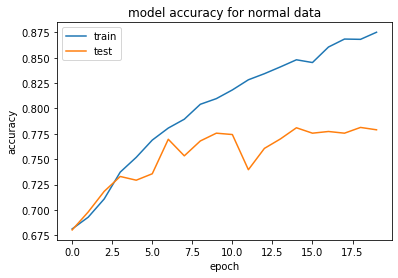

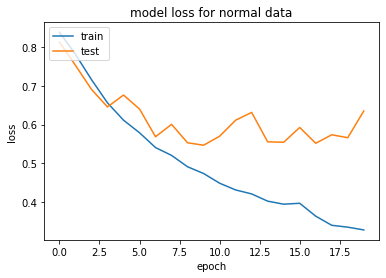

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for normal data')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for normal data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Dimensionality Reduction using PCA

### NOTE: Due to the large size of correlation matrix generated in this dataset, the PCA is taking too much time to run on the RAM. Therefore the code is commented out.

In [ ]:
#PCA is taking too long to run as correlation matrix is too large to accomodate in RAM
# scaler = StandardScaler()
# x_train_pca = np.copy(x_train)
# x_test_pca = np.copy(x_test)

# scaler.fit(x_train_pca)

# x_train_pca = scaler.transform(x_train_pca)
# x_test_pca = scaler.transform(x_test_pca)
# pca = PCA(0.95)
# pca.fit(x_train)              
# print("PCA number of components: ",pca.n_components_)
# x_train_pca = pca.transform(x_train_pca)
# x_test_pca = pca.transform(x_test_pca)

# pca_model = yelp_backprop(pca.n_components_.item(), 10)
# pca_model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
# pca_model.summary()
# pca_history = pca_model.fit(x = x_train_pca, y = Y_train, batch_size=32, epochs=10, validation_data=(x_test_pca, Y_test))